# Librerías y modelos

In [1]:
print(__doc__)

import numpy as np
import pandas as pd
#import pandas_profiling
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.ticker import FormatStrFormatter
import itertools
from sklearn import preprocessing

Automatically created module for IPython interactive environment


In [2]:
from matplotlib.colors import ListedColormap
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer, SCORERS
from sklearn.metrics import mean_squared_error
from sklearn.metrics import explained_variance_score
from sklearn.metrics import classification_report, confusion_matrix

from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression, Ridge, Lasso

## Recopilamos los modelos

In [3]:
names = ['LinearRegression', 'Ridge', 'Lasso', 'Decision Tree Reg', 'Nearest Neighbors Reg']
#         'Neural Net Reg']

classifiers = [
    LinearRegression(),
    Ridge(),
    Lasso(),
    DecisionTreeRegressor(), 
    KNeighborsRegressor()]
#    MLPRegressor(max_iter=1000)]

parametros=[{'copy_X': [True]},
            {'alpha': [0.1, 0.3, 1, 3, 10, 30, 100]},
            {'alpha': [0.1, 0.3, 1, 3, 10, 30, 100]},
            {'max_depth': range(2,21), 'min_samples_split': range(2,100,5)},
            {'n_neighbors': range(3,71,4)}]
#            {'hidden_layer_sizes': [(v,) for v in range(20,101,10)]}]

dict_modelos = {}
for i in range(len(names)):
    dict_modelos[names[i]]={'Modelo': classifiers[i], 'Params': parametros[i]}

dict_modelos

{'LinearRegression': {'Modelo': LinearRegression(),
  'Params': {'copy_X': [True]}},
 'Ridge': {'Modelo': Ridge(),
  'Params': {'alpha': [0.1, 0.3, 1, 3, 10, 30, 100]}},
 'Lasso': {'Modelo': Lasso(),
  'Params': {'alpha': [0.1, 0.3, 1, 3, 10, 30, 100]}},
 'Decision Tree Reg': {'Modelo': DecisionTreeRegressor(),
  'Params': {'max_depth': range(2, 21),
   'min_samples_split': range(2, 100, 5)}},
 'Nearest Neighbors Reg': {'Modelo': KNeighborsRegressor(),
  'Params': {'n_neighbors': range(3, 71, 4)}}}

# Sin bins y con items

## Carga y división de datos

In [4]:
data = pd.read_csv('Demographic_Data.csv')
data = data.rename(columns={name:name.capitalize() for name in data.columns})
data=data[['In-store','Region','Items','Amount','Age']]
data.head()

,In-store,Region,Items,Amount,Age
0,0,2,4,281.03,37
1,0,2,2,219.51,35
2,1,4,3,1525.70,45
3,1,3,3,715.25,46
4,1,1,4,1937.50,33


In [5]:
#features
X = data.iloc[:,0:4]
y = data.iloc[:,4]

In [6]:
#Train/Test Split (que conste que esta división no separa a partes iguales los datos de cada region, y esto puede ser un fallo)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .30, random_state = 123)

In [7]:
scaler = preprocessing.StandardScaler().fit(X_train.iloc[:,1:4])
X_tr_scaled = scaler.transform(X_train.iloc[:,1:4])
X_tr_scaled=pd.DataFrame(X_tr_scaled, columns=X_train.columns[1:4], index=X_train.index)
X_tr_scaled=pd.concat([X_train.iloc[:,[0]],X_tr_scaled],axis=1)
#X_tr_scaled

## Uso GridSearchCV

In [8]:
scorr = {'Exp. Var': 'explained_variance', 'R2': 'r2'}
cosas=[scorr.keys(),['mean_test_','rank_test_']]
cosas0=[]
for element in itertools.product(*cosas):
        cosas0.append(element[1]+element[0])

In [9]:
#Por defecto toma cv=5

mod_entrenados={}

for name in dict_modelos.keys():
    names_col_imp=[]
    cosas1=['param_'+v for v in dict_modelos[name]['Params'].keys()]
    names_col_imp=['params']+cosas1+cosas0
    
    gs = GridSearchCV(dict_modelos[name]['Modelo'],
                      param_grid=dict_modelos[name]['Params'],
                      scoring=scorr, refit='R2', cv=5)
    gs.fit(X_tr_scaled, y_train)
    mod_entrenados[name]={'Mod_ent': gs, 'Tabla': pd.DataFrame(gs.cv_results_)[names_col_imp], 'Best': gs.best_estimator_}
    print(f'Para el modelo {name}, el mejor estimador es {gs.best_estimator_}.')
    print()

Para el modelo LinearRegression, el mejor estimador es LinearRegression().

Para el modelo Ridge, el mejor estimador es Ridge(alpha=10).

Para el modelo Lasso, el mejor estimador es Lasso(alpha=0.1).

Para el modelo Decision Tree Reg, el mejor estimador es DecisionTreeRegressor(max_depth=5, min_samples_split=72).

Para el modelo Nearest Neighbors Reg, el mejor estimador es KNeighborsRegressor(n_neighbors=67).



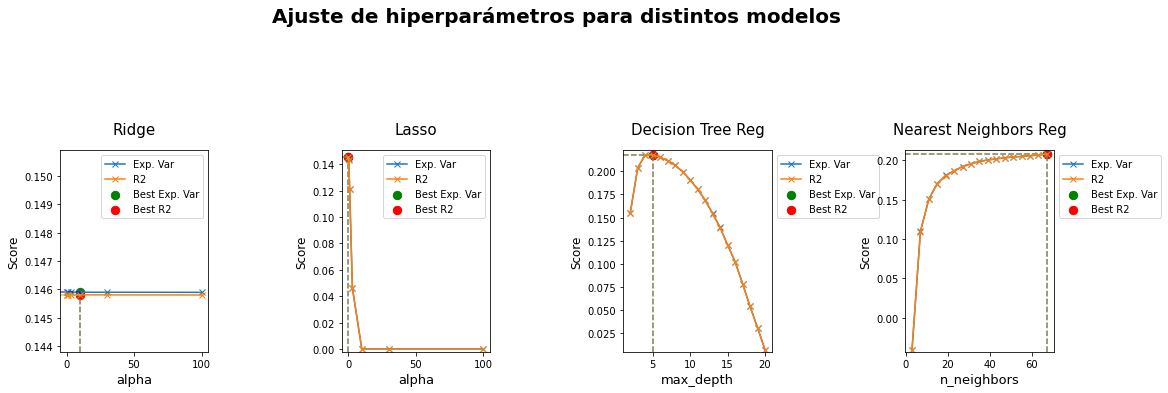

In [10]:
color = ['b', 'y']
color2 = ['g', 'r']
fig, axes_gs = plt.subplots(1,4)

j = 0
for n in list(mod_entrenados.keys())[1:]:
    j = j+1
    colu = 'param_'+list(parametros[j])[0]
    if j==3:
        resultados = mod_entrenados[n]['Tabla'][mod_entrenados[n]['Tabla']['param_min_samples_split']==2]
    else :
        resultados = mod_entrenados[n]['Tabla']
    axes_gs[j-1].set_ylim(min(resultados.iloc[:,-4].min(), resultados.iloc[:,-2].min())-0.002, max(resultados.iloc[:,-4].max(),resultados.iloc[:,-2].max())+0.005)
    for i in range(len(scorr)):   
        axes_gs[j-1].plot(resultados[colu], resultados.iloc[:,2*i-4], 'x-', label=list(scorr.keys())[i])
        fff=resultados[colu][resultados.iloc[:,2*i-3]==resultados.iloc[:,2*i-3].min()]
        axes_gs[j-1].scatter(fff,np.full((1,len(fff)),resultados.iloc[:,2*i-4].max()), s=70, color = color2[i], label='Best '+list(scorr.keys())[i])
        limite_y=(resultados.iloc[:,2*i-4].max()-axes_gs[j-1].set_ylim()[0])/(axes_gs[j-1].set_ylim()[1]-axes_gs[j-1].set_ylim()[0])
        for k in range(len(fff)):
            limite_x=(resultados[colu][resultados.iloc[:,2*i-3]==resultados.iloc[:,2*i-3].min()].unique()[k]-axes_gs[j-1].set_xlim()[0])/(axes_gs[j-1].set_xlim()[1]-axes_gs[j-1].set_xlim()[0])
            axes_gs[j-1].axhline(resultados.iloc[:,2*i-4].max(), xmax=limite_x, ls='--', color=color[i], alpha=0.7)
            axes_gs[j-1].axvline(resultados[colu][resultados.iloc[:,2*i-3]==resultados.iloc[:,2*i-3].min()].unique()[k], ymax=limite_y, ls='--', color=color[i], alpha=0.7)
    axes_gs[j-1].legend(bbox_to_anchor=(1, 1))
    axes_gs[j-1].set_xlabel(list(parametros[j])[0], size=13)
    axes_gs[j-1].set_ylabel('Score', size=12)
    axes_gs[j-1].set_title(n, size=15, y =1.05)

plt.subplots_adjust(left=0,
                    bottom=0, 
                    right=2.3, 
                    top=0.7, 
                    wspace=0.9, 
                    hspace=0.5)
fig.suptitle('Ajuste de hiperparámetros para distintos modelos', size=20, x=1.15, y=1.2, fontweight ="bold")
plt.show()
#plt.xticks(list(range(0,29)), resultados.param_max_depth);

## Entreno los best estimator y comparo

Primero modificamos los datos X_test para adecuarlos a la escala:

In [11]:
X_test_scaled = scaler.transform(X_test.iloc[:,1:4])
X_test_scaled=pd.DataFrame(X_test_scaled, columns=X_test.columns[1:4], index=X_test.index)
X_test_scaled=pd.concat([X_test.iloc[:,[0]],X_test_scaled],axis=1)

In [52]:
bins=np.array([17.999,25.001,35.001,45.001,55.001,65.001,75.001,85.001])
agrupa_ages_real = np.digitize(y_train, bins)

for name in mod_entrenados.keys():
    model = mod_entrenados[name]['Best'].fit(X_tr_scaled, y_train)
    preds = model.predict(X_tr_scaled)
    mod_entrenados[name]['Preds_for_best'] = preds
    
    agrupa_ages_predict = np.digitize(preds, bins)
    mat_conf_prueba=np.empty((len(bins)-1,len(bins)-1))
    for i in range(len(bins)-1):
        for j in range(len(bins)-1):
            mat_conf_prueba[i,j]=len(agrupa_ages_real[(agrupa_ages_real==i+1)&(agrupa_ages_predict==j+1)])
    confmatriz=pd.DataFrame(mat_conf_prueba,
                        index=['18-25','26-35','36-45','46-55','56-65','66-75','76-85'],
                        columns=['18-25','26-35','36-45','46-55','56-65','66-75','76-85'])
    mod_entrenados[name]['Conf_mat']=confmatriz
    
    f1=np.empty((1,len(bins)-1))
    sup=np.empty((1,len(bins)-1))
    for i in range(len(bins)-1):
        if np.sum(mat_conf_prueba,axis=0)[i]!=0:
            prec=mat_conf_prueba[i,i]/np.sum(mat_conf_prueba,axis=0)[i]
            recall=mat_conf_prueba[i,i]/np.sum(mat_conf_prueba,axis=1)[i]
            if prec+recall!=0: f1[0][i]=2*prec*recall/(prec+recall)
            else: f1[0][i]=0
        else:
            f1[0][i]=0      
        sup[0][i]=sum(agrupa_ages_real==i+1)
    f1_mean=np.nansum(f1)/len(f1[0])
    f1_weighted=np.nansum(f1*sup)/np.nansum(sup)
    accuracy=np.trace(mat_conf_prueba)/sum(sum(mat_conf_prueba))
    f1_score=list(f1[0])+[accuracy]+[f1_mean]+[f1_weighted]
    
    
    mod_entrenados[name]['Class_report']=pd.DataFrame({'f1-score': f1_score})
    
    try :
        mod_entrenados[name]['Imp_features'] = pd.DataFrame(model.feature_importances_, index=X_tr_scaled.columns, columns=['Importance']).transpose()
    except:
        pass
    
    
    print(name)

LinearRegression
Ridge
Lasso
Decision Tree Reg
Nearest Neighbors Reg


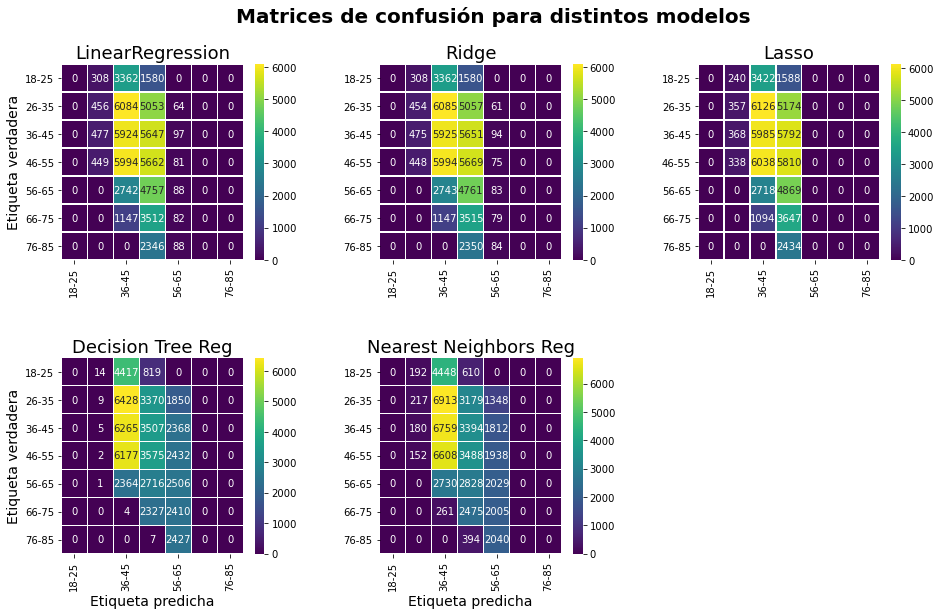

In [53]:
fig, axs = plt.subplots(2,3)
j=-1
for name in mod_entrenados.keys():
    j=j+1
    sns.heatmap(mod_entrenados[name]['Conf_mat'], vmin=0,annot=True,cmap='viridis', fmt='1.0f',linewidths=.2, ax=axs[j//3,j%3])
    axs[j//3,j%3].set_title(name, fontsize=18)
    if j//3==1 : axs[j//3,j%3].set_xlabel('Etiqueta predicha',size=14)
    if j%3 ==0: axs[j//3,j%3].set_ylabel('Etiqueta verdadera',size=14)
    
plt.subplots_adjust(left=0,
                    bottom=0, 
                    right=2, 
                    top=1.7, 
                    wspace=0.4, 
                    hspace=0.5)
 
axs[-1, -1].axis('off')
fig.suptitle('Matrices de confusión para distintos modelos', size=20, x=1, y=1.9, fontweight ="bold")
plt.show()

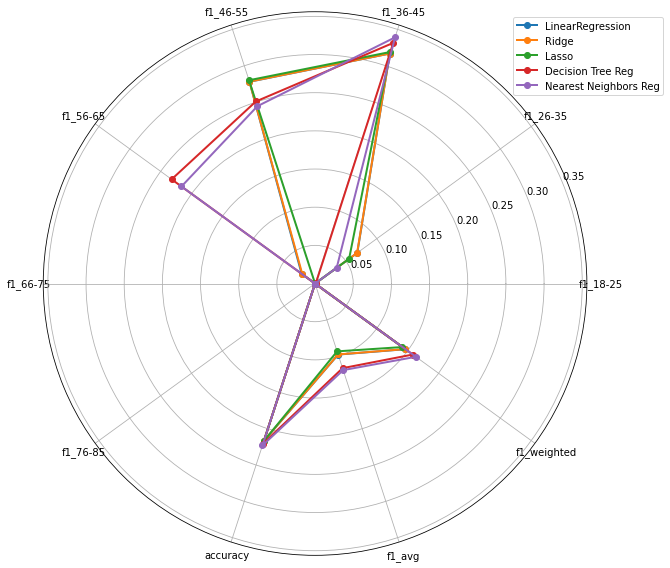

In [54]:
labels=['f1_18-25', 'f1_26-35', 'f1_36-45', 'f1_46-55', 'f1_56-65', 'f1_66-75', 'f1_76-85',
        'accuracy','f1_avg', 'f1_weighted']
color=['tab:blue', 'tab:orange','tab:green','tab:red','tab:purple','tab:brown','tab:pink','tab:grey']
# Preparación de datos de dibujo, ángulo, valor de estado
angles=np.linspace(0, 2*np.pi, len(labels), endpoint=False)
angles=np.concatenate((angles,[angles[0]]))
# Usa Matplotlib para dibujar diagramas de araña
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111, polar=True)
ax.set_thetagrids(angles[0:10] * 180/np.pi, labels)
#ax.set_rlim([0.55,0.65])
#ax.set_rticks([0.58,0.62])

#for i in range(2):
for name in mod_entrenados.keys():
    stats= mod_entrenados[name]['Class_report']['f1-score']
    stats=np.concatenate((stats,[stats[0]]))
    ax.plot(angles, stats, 'o-', linewidth=2, label=name)
#    ax.fill(angles, stats, alpha=0.25)
plt.legend(bbox_to_anchor=(1.15, 1))
plt.show()

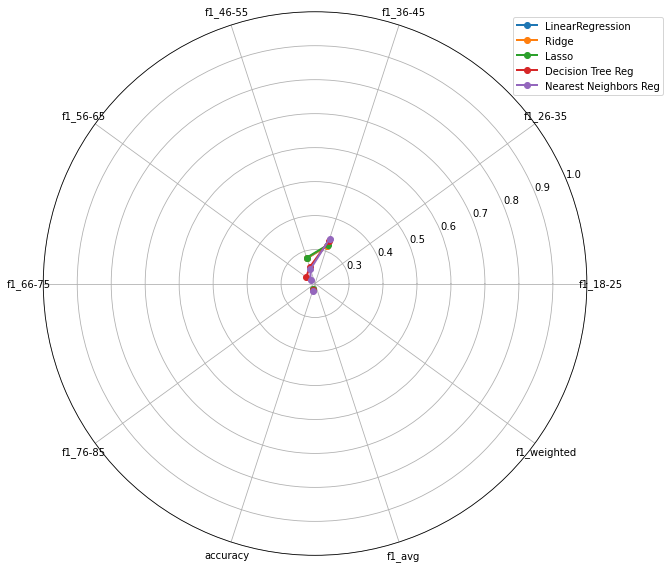

In [55]:
labels=['f1_18-25', 'f1_26-35', 'f1_36-45', 'f1_46-55', 'f1_56-65', 'f1_66-75', 'f1_76-85',
        'accuracy','f1_avg', 'f1_weighted']
color=['tab:blue', 'tab:orange','tab:green','tab:red','tab:purple','tab:brown','tab:pink','tab:grey']
# Preparación de datos de dibujo, ángulo, valor de estado
angles=np.linspace(0, 2*np.pi, len(labels), endpoint=False)
angles=np.concatenate((angles,[angles[0]]))
# Usa Matplotlib para dibujar diagramas de araña
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111, polar=True)
ax.set_thetagrids(angles[0:10] * 180/np.pi, labels)
ax.set_rlim([0.2,1])
#ax.set_rticks([0.58,0.62])

#for i in range(2):
for i in range(5):
    stats= mod_entrenados[list(mod_entrenados.keys())[i]]['Class_report']['f1-score']
    stats=np.concatenate((stats,[stats[0]]))
    ax.plot(angles, stats, 'o-', linewidth=2, label=list(mod_entrenados.keys())[i])
#    ax.fill(angles, stats, alpha=0.25)
plt.legend(bbox_to_anchor=(1.15, 1))
plt.show()

# Sin bins y sin items

## Carga y división de datos

In [16]:
#features
X_si = data.iloc[:,[0,1,3]]
y_si = data.iloc[:,4]

In [17]:
#Train/Test Split (que conste que esta división no separa a partes iguales los datos de cada region, y esto puede ser un fallo)
X_si_train, X_si_test, y_si_train, y_si_test = train_test_split(X_si, y_si, test_size = .30, random_state = 123)

In [18]:
scaler_si = preprocessing.StandardScaler().fit(X_si_train.iloc[:,1:3])
X_si_tr_scaled = scaler_si.transform(X_si_train.iloc[:,1:3])
X_si_tr_scaled=pd.DataFrame(X_si_tr_scaled, columns=X_si_train.columns[1:3], index=X_si_train.index)
X_si_tr_scaled=pd.concat([X_si_train.iloc[:,[0]],X_si_tr_scaled],axis=1)

## Uso GridSearchCV

In [19]:
scorr = {'Exp. Var': 'explained_variance', 'R2': 'r2'}
cosas=[scorr.keys(),['mean_test_','rank_test_']]
cosas0=[]
for element in itertools.product(*cosas):
        cosas0.append(element[1]+element[0])

In [20]:
#Por defecto toma cv=5

mod_entrenados_si={}

for name in dict_modelos.keys():
    names_col_imp=[]
    cosas1=['param_'+v for v in dict_modelos[name]['Params'].keys()]
    names_col_imp=['params']+cosas1+cosas0
    
    gs = GridSearchCV(dict_modelos[name]['Modelo'],
                      param_grid=dict_modelos[name]['Params'],
                      scoring=scorr, refit='R2', cv=5)
    gs.fit(X_si_tr_scaled, y_si_train)
    mod_entrenados_si[name]={'Mod_ent': gs, 'Tabla': pd.DataFrame(gs.cv_results_)[names_col_imp], 'Best': gs.best_estimator_}
    print(f'Para el modelo {name}, el mejor estimador es {gs.best_estimator_}.')
    print()

Para el modelo LinearRegression, el mejor estimador es LinearRegression().

Para el modelo Ridge, el mejor estimador es Ridge(alpha=3).

Para el modelo Lasso, el mejor estimador es Lasso(alpha=0.1).

Para el modelo Decision Tree Reg, el mejor estimador es DecisionTreeRegressor(max_depth=5).

Para el modelo Nearest Neighbors Reg, el mejor estimador es KNeighborsRegressor(n_neighbors=67).



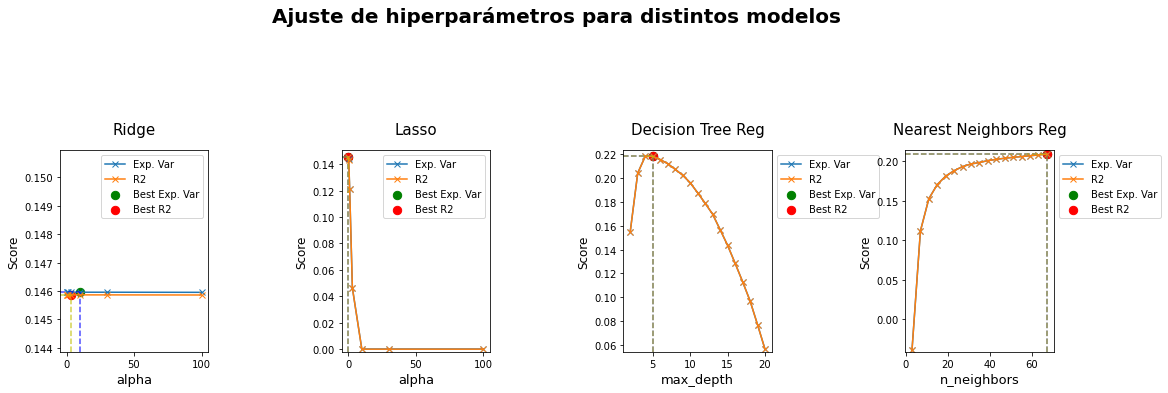

In [21]:
color = ['b', 'y']
color2 = ['g', 'r']
fig, axes_gs = plt.subplots(1,4)

j = 0
for n in list(mod_entrenados_si.keys())[1:]:
    j = j+1
    colu = 'param_'+list(parametros[j])[0]
    if j==3:
        resultados = mod_entrenados_si[n]['Tabla'][mod_entrenados_si[n]['Tabla']['param_min_samples_split']==2]
    else :
        resultados = mod_entrenados_si[n]['Tabla']
    axes_gs[j-1].set_ylim(min(resultados.iloc[:,-4].min(), resultados.iloc[:,-2].min())-0.002, max(resultados.iloc[:,-4].max(),resultados.iloc[:,-2].max())+0.005)
    for i in range(len(scorr)):   
        axes_gs[j-1].plot(resultados[colu], resultados.iloc[:,2*i-4], 'x-', label=list(scorr.keys())[i])
        fff=resultados[colu][resultados.iloc[:,2*i-3]==resultados.iloc[:,2*i-3].min()]
        axes_gs[j-1].scatter(fff,np.full((1,len(fff)),resultados.iloc[:,2*i-4].max()), s=70, color = color2[i], label='Best '+list(scorr.keys())[i])
        limite_y=(resultados.iloc[:,2*i-4].max()-axes_gs[j-1].set_ylim()[0])/(axes_gs[j-1].set_ylim()[1]-axes_gs[j-1].set_ylim()[0])
        for k in range(len(fff)):
            limite_x=(resultados[colu][resultados.iloc[:,2*i-3]==resultados.iloc[:,2*i-3].min()].unique()[k]-axes_gs[j-1].set_xlim()[0])/(axes_gs[j-1].set_xlim()[1]-axes_gs[j-1].set_xlim()[0])
            axes_gs[j-1].axhline(resultados.iloc[:,2*i-4].max(), xmax=limite_x, ls='--', color=color[i], alpha=0.7)
            axes_gs[j-1].axvline(resultados[colu][resultados.iloc[:,2*i-3]==resultados.iloc[:,2*i-3].min()].unique()[k], ymax=limite_y, ls='--', color=color[i], alpha=0.7)
    axes_gs[j-1].legend(bbox_to_anchor=(1, 1))
    axes_gs[j-1].set_xlabel(list(parametros[j])[0], size=13)
    axes_gs[j-1].set_ylabel('Score', size=12)
    axes_gs[j-1].set_title(n, size=15, y =1.05)

plt.subplots_adjust(left=0,
                    bottom=0, 
                    right=2.3, 
                    top=0.7, 
                    wspace=0.9, 
                    hspace=0.5)
fig.suptitle('Ajuste de hiperparámetros para distintos modelos', size=20, x=1.15, y=1.2, fontweight ="bold")
plt.show()
#plt.xticks(list(range(0,29)), resultados.param_max_depth);

## Entreno los best estimator y comparo

Primero modificamos los datos X_test para adecuarlos a la escala:

In [22]:
X_si_test_scaled = scaler_si.transform(X_si_test.iloc[:,1:3])
X_si_test_scaled=pd.DataFrame(X_si_test_scaled, columns=X_si_test.columns[1:3], index=X_si_test.index)
X_si_test_scaled=pd.concat([X_si_test.iloc[:,[0]],X_si_test_scaled],axis=1)

In [56]:
bins=np.array([17.999,25.001,35.001,45.001,55.001,65.001,75.001,85.001])
agrupa_ages_real = np.digitize(y_si_train, bins)

for name in mod_entrenados_si.keys():
    model = mod_entrenados_si[name]['Best'].fit(X_si_tr_scaled, y_si_train)
    preds = model.predict(X_si_tr_scaled)
    mod_entrenados_si[name]['Preds_for_best'] = preds
    
    agrupa_ages_predict = np.digitize(preds, bins)
    mat_conf_prueba=np.empty((len(bins)-1,len(bins)-1))
    for i in range(len(bins)-1):
        for j in range(len(bins)-1):
            mat_conf_prueba[i,j]=len(agrupa_ages_real[(agrupa_ages_real==i+1)&(agrupa_ages_predict==j+1)])
    confmatriz=pd.DataFrame(mat_conf_prueba,
                        index=['18-25','26-35','36-45','46-55','56-65','66-75','76-85'],
                        columns=['18-25','26-35','36-45','46-55','56-65','66-75','76-85'])
    mod_entrenados_si[name]['Conf_mat']=confmatriz
    
    f1=np.empty((1,len(bins)-1))
    sup=np.empty((1,len(bins)-1))
    for i in range(len(bins)-1):
        if np.sum(mat_conf_prueba,axis=0)[i]!=0:
            prec=mat_conf_prueba[i,i]/np.sum(mat_conf_prueba,axis=0)[i]
            recall=mat_conf_prueba[i,i]/np.sum(mat_conf_prueba,axis=1)[i]
            if prec+recall!=0: f1[0][i]=2*prec*recall/(prec+recall)
            else: f1[0][i]=0
        else:
            f1[0][i]=0      
        sup[0][i]=sum(agrupa_ages_real==i+1)
    f1_mean=np.nansum(f1)/len(f1[0])
    f1_weighted=np.nansum(f1*sup)/np.nansum(sup)
    accuracy=np.trace(mat_conf_prueba)/sum(sum(mat_conf_prueba))
    f1_score=list(f1[0])+[accuracy]+[f1_mean]+[f1_weighted]
    
    
    mod_entrenados_si[name]['Class_report']=pd.DataFrame({'f1-score': f1_score})
    
    try :
        mod_entrenados_si[name]['Imp_features'] = pd.DataFrame(model.feature_importances_, index=X_tr_scaled.columns, columns=['Importance']).transpose()
    except:
        pass
    
    
    print(name)

LinearRegression
Ridge
Lasso
Decision Tree Reg
Nearest Neighbors Reg


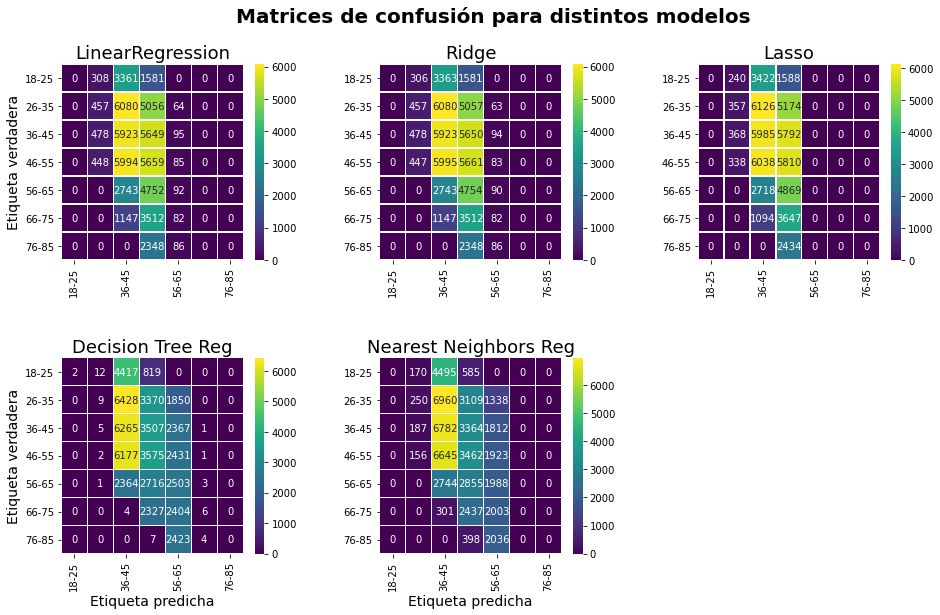

In [57]:
fig, axs = plt.subplots(2,3)
j=-1
for name in mod_entrenados_si.keys():
    j=j+1
    sns.heatmap(mod_entrenados_si[name]['Conf_mat'], vmin=0,annot=True,cmap='viridis', fmt='1.0f',linewidths=.2, ax=axs[j//3,j%3])
    axs[j//3,j%3].set_title(name, fontsize=18)
    if j//3==1 : axs[j//3,j%3].set_xlabel('Etiqueta predicha',size=14)
    if j%3 ==0: axs[j//3,j%3].set_ylabel('Etiqueta verdadera',size=14)
    
plt.subplots_adjust(left=0,
                    bottom=0, 
                    right=2, 
                    top=1.7, 
                    wspace=0.4, 
                    hspace=0.5)
 
axs[-1, -1].axis('off')
fig.suptitle('Matrices de confusión para distintos modelos', size=20, x=1, y=1.9, fontweight ="bold")
plt.show()

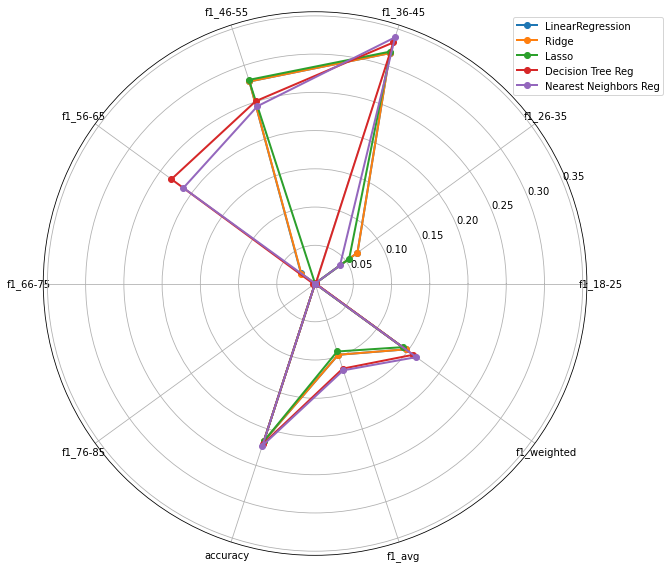

In [58]:
labels=['f1_18-25', 'f1_26-35', 'f1_36-45', 'f1_46-55', 'f1_56-65', 'f1_66-75', 'f1_76-85',
        'accuracy','f1_avg', 'f1_weighted']
color=['tab:blue', 'tab:orange','tab:green','tab:red','tab:purple','tab:brown','tab:pink','tab:grey']
# Preparación de datos de dibujo, ángulo, valor de estado
angles=np.linspace(0, 2*np.pi, len(labels), endpoint=False)
angles=np.concatenate((angles,[angles[0]]))
# Usa Matplotlib para dibujar diagramas de araña
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111, polar=True)
ax.set_thetagrids(angles[0:10] * 180/np.pi, labels)
#ax.set_rlim([0.55,0.65])
#ax.set_rticks([0.58,0.62])

#for i in range(2):
for name in mod_entrenados_si.keys():
    stats= mod_entrenados_si[name]['Class_report']['f1-score']
    stats=np.concatenate((stats,[stats[0]]))
    ax.plot(angles, stats, 'o-', linewidth=2, label=name)
#    ax.fill(angles, stats, alpha=0.25)
plt.legend(bbox_to_anchor=(1.15, 1))
plt.show()

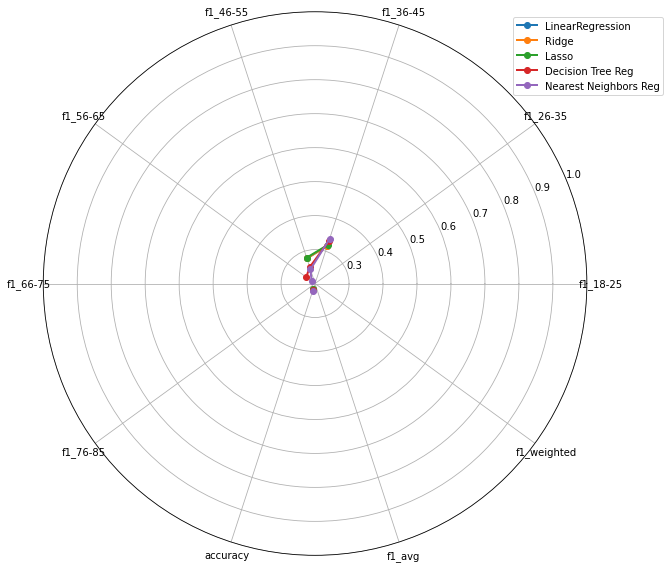

In [59]:
labels=['f1_18-25', 'f1_26-35', 'f1_36-45', 'f1_46-55', 'f1_56-65', 'f1_66-75', 'f1_76-85',
        'accuracy','f1_avg', 'f1_weighted']
color=['tab:blue', 'tab:orange','tab:green','tab:red','tab:purple','tab:brown','tab:pink','tab:grey']
# Preparación de datos de dibujo, ángulo, valor de estado
angles=np.linspace(0, 2*np.pi, len(labels), endpoint=False)
angles=np.concatenate((angles,[angles[0]]))
# Usa Matplotlib para dibujar diagramas de araña
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111, polar=True)
ax.set_thetagrids(angles[0:10] * 180/np.pi, labels)
ax.set_rlim([0.2,1])
#ax.set_rticks([0.58,0.62])

#for i in range(2):
for i in range(5):
    stats= mod_entrenados_si[list(mod_entrenados_si.keys())[i]]['Class_report']['f1-score']
    stats=np.concatenate((stats,[stats[0]]))
    ax.plot(angles, stats, 'o-', linewidth=2, label=list(mod_entrenados_si.keys())[i])
#    ax.fill(angles, stats, alpha=0.25)
plt.legend(bbox_to_anchor=(1.15, 1))
plt.show()

# Eligiendo el mejor modelo

In [60]:
lista_modelos=[mod_entrenados,mod_entrenados_si]
li_mod=['mod_entrenados ','mod_entrenados_si ']

In [61]:
todos_modelos_var={}
todos_modelos_r2={}
todos_modelos_acc={}
todos_modelos_f1={}
todos_modelos_mean4={}
todos_modelos_mean={}
for i in range(len(lista_modelos)):
    for name2 in lista_modelos[i]:
        todos_modelos_var[li_mod[i]+name2] = list(lista_modelos[i][name2]['Tabla'][lista_modelos[i][name2]['Tabla']['rank_test_R2']==1]['mean_test_Exp. Var'])[0]
        todos_modelos_r2[li_mod[i]+name2] = list(lista_modelos[i][name2]['Tabla'][lista_modelos[i][name2]['Tabla']['rank_test_R2']==1]['mean_test_R2'])[0]
        todos_modelos_acc[li_mod[i]+name2] = lista_modelos[i][name2]['Class_report']['f1-score'][7]
        todos_modelos_f1[li_mod[i]+name2] = lista_modelos[i][name2]['Class_report']['f1-score'][9] 
        todos_modelos_mean4[li_mod[i]+name2] = (todos_modelos_acc[li_mod[i]+name2]+todos_modelos_f1[li_mod[i]+name2]+todos_modelos_r2[li_mod[i]+name2]+todos_modelos_var[li_mod[i]+name2])/4
        todos_modelos_mean[li_mod[i]+name2] = (todos_modelos_acc[li_mod[i]+name2]+todos_modelos_f1[li_mod[i]+name2])/2

In [62]:
def maxdict(di):
    f=0
    ff=''
    for n, m in di.items():
        if m>f: 
            f=m
            ff=n
    return ff

In [63]:
mas_var=maxdict(todos_modelos_var)
mas_r2=maxdict(todos_modelos_r2)
mas_acc=maxdict(todos_modelos_acc)
mas_f1=maxdict(todos_modelos_f1)
mas_mean4=maxdict(todos_modelos_mean4)
mas_mean=maxdict(todos_modelos_mean)
print(f'El modelo con mayor exp. var. es {mas_var}: {todos_modelos_var[mas_var]}')
print(f'El modelo con mayor r2 es {mas_r2}: {todos_modelos_r2[mas_r2]}')
print(f'El modelo con mayor accuracy es {mas_acc}: {todos_modelos_acc[mas_acc]}')
print(f'El modelo con mayor f1-score es {mas_f1}: {todos_modelos_f1[mas_f1]}')
print(f'El modelo con mayor score medio es {mas_mean4}: {todos_modelos_mean4[mas_mean4]}')
print(f'El modelo con mayor score medio (solo contando acc y f1) es {mas_mean}: {todos_modelos_mean[mas_mean]}')

El modelo con mayor exp. var. es mod_entrenados_si Decision Tree Reg: 0.2177987182617221
El modelo con mayor r2 es mod_entrenados_si Decision Tree Reg: 0.21775867745151353
El modelo con mayor accuracy es mod_entrenados Nearest Neighbors Reg: 0.2230892857142857
El modelo con mayor f1-score es mod_entrenados_si Nearest Neighbors Reg: 0.16367723924936012
El modelo con mayor score medio es mod_entrenados_si Decision Tree Reg: 0.20369920891783522
El modelo con mayor score medio (solo contando acc y f1) es mod_entrenados_si Nearest Neighbors Reg: 0.19328504819610864


In [65]:
mod_entrenados_si['Nearest Neighbors Reg']['Best']

KNeighborsRegressor(n_neighbors=67)

In [67]:
bins=np.array([17.999,25.001,35.001,45.001,55.001,65.001,75.001,85.001])
agrupa_ages_real = np.digitize(y_si_test, bins)

mejor_model = mod_entrenados_si['Nearest Neighbors Reg']['Best'].fit(X_si_tr_scaled, y_si_train)
preds = mejor_model.predict(X_si_test_scaled)

agrupa_ages_predict = np.digitize(preds, bins)
mat_conf_prueba=np.empty((len(bins)-1,len(bins)-1))
for i in range(len(bins)-1):
    for j in range(len(bins)-1):
        mat_conf_prueba[i,j]=len(agrupa_ages_real[(agrupa_ages_real==i+1)&(agrupa_ages_predict==j+1)])
    
f1=np.empty((1,len(bins)-1))
sup=np.empty((1,len(bins)-1))
for i in range(len(bins)-1):
    if np.sum(mat_conf_prueba,axis=0)[i]!=0:
        prec=mat_conf_prueba[i,i]/np.sum(mat_conf_prueba,axis=0)[i]
        recall=mat_conf_prueba[i,i]/np.sum(mat_conf_prueba,axis=1)[i]
        if prec+recall!=0: f1[0][i]=2*prec*recall/(prec+recall)
        else: f1[0][i]=0
    else:
        f1[0][i]=0      
    sup[0][i]=sum(agrupa_ages_real==i+1)
f1_mean=np.nansum(f1)/len(f1[0])
f1_weighted=np.nansum(f1*sup)/np.nansum(sup)
accuracy=np.trace(mat_conf_prueba)/sum(sum(mat_conf_prueba))
f1_score=list(f1[0])+[accuracy]+[f1_mean]+[f1_weighted]
    
    
class_rep_mejor=pd.DataFrame({'f1-score': f1_score})
class_rep_mejor

,f1-score
0,0.000000
1,0.027088
2,0.340308
3,0.219980
4,0.204625
5,0.000000
6,0.000000
7,0.215333
8,0.113143
9,0.155976
